In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import IsolationForest
#from sklearn.neighbors import LocalOutlierFactor
import hdbscan
from sklearn.metrics import (
    silhouette_score, confusion_matrix, classification_report,
    precision_recall_fscore_support
)
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
import time

sns.set(style="whitegrid")

# Like the name says, an heartbeat, to check if the system is alive
import threading, time

def heartbeat():
    while True:
        time.sleep(3600)  # 1 hour
        print("Running...")

thread = threading.Thread(target=heartbeat, daemon=True)
thread.start()

import json
from copy import deepcopy


Running...
Running...


In [2]:
# -------------------------
# 0. Config / Paths
# -------------------------
TRAIN_PATH = r'X:\Dissertacao\python_projects\dataset\ISCX-Bot-2014\ISCX_csv\Testing_file.csv'
TEST_PATH  = r'X:\Dissertacao\python_projects\dataset\ISCX-Bot-2014\ISCX_csv\Training_file.csv'
LABEL_COL = "Label"   # set to your label column name if exists, otherwise leave as-is
SAMPLE_FOR_SIL = 100_000
SIL_BATCH = 100_000
#LOF_BATCH = 100_000
HDBSCAN_BATCH = 100_000
RANDOM_STATE = 42

# -------------------------
# 1. Load data
# -------------------------
def load_datasets(train_path, test_path):
    df_tr = pd.read_csv(train_path, encoding='ISO-8859-1')
    df_te = pd.read_csv(test_path, encoding='ISO-8859-1')
    return df_tr, df_te

df_train, df_test = load_datasets(TRAIN_PATH, TEST_PATH)


In [3]:
# -------------------------
# 2. Basic cleaning
# -------------------------
# Fill Info NaNs and drop rows missing Source/Destination
df_train['Info'].fillna("Unknown", inplace=True)
df_test['Info'].fillna("Unknown", inplace=True)
df_train.dropna(subset=['Source','Destination'], inplace=True)
df_test.dropna(subset=['Source','Destination'], inplace=True)

# Remove rows with negative Time (if that's desired)
df_train = df_train[df_train['Time'] >= 0].copy()
df_test  = df_test[df_test['Time'] >= 0].copy()

# -------------------------
# 3. Build global mappings
# -------------------------

def build_mapping(train_col, test_col, name):
    """Create a dictionary mapping for train+test, save to JSON, return mapping."""
    all_values = pd.concat([train_col, test_col]).unique()
    mapping = {val: idx for idx, val in enumerate(all_values)}

    # optional: save for reproducibility
    with open(f"{name}_mapping.json", "w") as f:
        json.dump(mapping, f)

    return mapping

# Protocol
protocol_mapping = build_mapping(df_train['Protocol'], df_test['Protocol'], "protocol")
df_train['Protocol_enc'] = df_train['Protocol'].map(protocol_mapping).fillna(-1).astype(int)
df_test['Protocol_enc']  = df_test['Protocol'].map(protocol_mapping).fillna(-1).astype(int)

# Source
source_mapping = build_mapping(df_train['Source'], df_test['Source'], "source")
df_train['Source_enc'] = df_train['Source'].map(source_mapping).fillna(-1).astype(int)
df_test['Source_enc']  = df_test['Source'].map(source_mapping).fillna(-1).astype(int)

# Destination
dest_mapping = build_mapping(df_train['Destination'], df_test['Destination'], "destination")
df_train['Destination_enc'] = df_train['Destination'].map(dest_mapping).fillna(-1).astype(int)
df_test['Destination_enc']  = df_test['Destination'].map(dest_mapping).fillna(-1).astype(int)

# ==================== Drop originals (optional) ==================== #
# Keep only the encoded versions for modeling
df_train.drop(['Protocol', 'Source', 'Destination'], axis=1, inplace=True)
df_test.drop(['Protocol', 'Source', 'Destination'], axis=1, inplace=True)


C:\Users\alexs\AppData\Local\Temp\ipykernel_1656\193201210.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train['Info'].fillna("Unknown", inplace=True)
C:\Users\alexs\AppData\Local\Temp\ipykernel_1656\193201210.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example

In [6]:
# -------------------------
# 4. Feature engineering
# -------------------------
def build_features(df):
    # Time diff per Source
    df['Time_Diff'] = df.groupby("Source_enc")['Time'].diff()
    df['Time_Diff'] = df['Time_Diff'].fillna(df.groupby('Source_enc')['Time'].transform('median'))
    df['Time_Diff'] = df['Time_Diff'].fillna(0.0)

    # Packet rate (IQR filter)
    def packet_rate(series):
        if len(series) < 2:
            return 0.0
        q1, q3 = np.percentile(series, [25, 75])
        iqr = max(q3 - q1, 1e-9)
        clipped = np.clip(series, q1 - 1.5 * iqr, q3 + 1.5 * iqr)
        denom = clipped.max() - clipped.min()
        denom = denom if denom > 1e-6 else 1e-6
        return len(clipped) / denom
    df['Packet_Rate'] = df.groupby('Source_enc')['Time'].transform(packet_rate)

    # Inter-arrival time (rolling mean)
    df['Inter_Arrival_Time'] = df.groupby('Source_enc')['Time_Diff'].transform(
        lambda x: x.rolling(10, min_periods=1).mean()
    ).clip(lower=1e-6)
    df['Burst_Rate'] = np.where(df['Inter_Arrival_Time'] > 1e-6, 1.0 / df['Inter_Arrival_Time'], 0.0)

    # Variability features
    df['Length_Mean'] = df.groupby("Source_enc")['Length'].transform('mean')
    df['Length_Std']  = df.groupby("Source_enc")['Length'].transform('std').fillna(0)
    df['Pkt_Per_Src'] = df.groupby("Source_enc")['Length'].transform('count')

    # NEW: Session duration (per source & destination)
    df['Session_Dur_Src'] = df.groupby("Source_enc")['Time'].transform(lambda x: x.max() - x.min())
    df['Session_Dur_Dst'] = df.groupby("Destination_enc")['Time'].transform(lambda x: x.max() - x.min())

    # Transforms
    df['Log_IATime'] = np.log1p(df['Inter_Arrival_Time'])
    df['Log_BRate']  = np.log1p(df['Burst_Rate'].clip(lower=0))

    # BoxCox requires positive
    df['BoxCox_Length'] = df['Length'] + 1e-3
    df['BoxCox_Length'], _ = boxcox(df['BoxCox_Length'])

    df['BoxCox_PRate'] = df['Packet_Rate'] + 1e-6
    try:
        df['BoxCox_PRate'], _ = boxcox(df['BoxCox_PRate'])
    except Exception:
        df['BoxCox_PRate'] = np.log1p(df['Packet_Rate'])

    return df

df_train = build_features(df_train)
df_test  = build_features(df_test)


In [7]:
# -------------------------
# 5. Select features & scale (fit scaler on train, apply to test)
# -------------------------
NUM_FEATURES = [
    "Time_Diff","Log_IATime","Log_BRate",
    "BoxCox_Length","BoxCox_PRate",
    "Length_Mean","Length_Std","Pkt_Per_Src",
    "Session_Dur_Src","Session_Dur_Dst"  # NEW FEATURES
]

scaler = MinMaxScaler()
scaler.fit(df_train[NUM_FEATURES])
df_train_scaled = pd.DataFrame(scaler.transform(df_train[NUM_FEATURES]), columns=NUM_FEATURES)
df_test_scaled  = pd.DataFrame(scaler.transform(df_test[NUM_FEATURES]), columns=NUM_FEATURES)

# Small de-duplication + tiny noise to avoid LOF duplicate issues
df_train_scaled = df_train_scaled.drop_duplicates().reset_index(drop=True)
df_test_scaled  = df_test_scaled.drop_duplicates().reset_index(drop=True)
df_train_scaled += np.random.normal(0, 1e-6, df_train_scaled.shape).astype("float32")
df_test_scaled  += np.random.normal(0, 1e-6, df_test_scaled.shape).astype("float32")

# Reduce precision to save memory
df_train_scaled = df_train_scaled.astype("float32")
df_test_scaled  = df_test_scaled.astype("float32")

# We'll keep copies of the scaled frames with indexes aligned to original for backreference:
df_train_scaled_full = df_train_scaled.copy()
df_test_scaled_full  = df_test_scaled.copy()

In [8]:
# -------------------------
# 6. Train Isolation Forest
# -------------------------
iso_forest = IsolationForest(
    n_estimators = 550,
    contamination = 0.1,
    max_samples = 0.2,
    random_state = 45,
    verbose = 0)

t0 = time.time()
iso_forest.fit(df_train_scaled_full)
t1 = time.time()
print(f"IsolationForest trained in {t1-t0:.1f}s")

df_train_scaled_full["Anomaly_IForest"] = iso_forest.predict(df_train_scaled_full)
df_test_scaled_full  = df_test_scaled_full if 'df_test_scaled_full' in globals() else df_test_scaled.copy()
df_test_scaled_full["Anomaly_IForest"] = iso_forest.predict(df_test_scaled)

# Convert labels to -1/1 convention (already so)
print("IForest train anomaly DONE")

IsolationForest trained in 35.6s
IForest train anomaly DONE


In [ ]:
# -------------------------
# 7. HDBSCAN clustering with PCA reduction
# -------------------------

def hdbscan_predict_batched(X, batch_size=HDBSCAN_BATCH, min_cluster_size=50, min_samples=None):
    """
    Runs PCA -> HDBSCAN on batches of data.
    Assigns -1 = anomaly (noise), otherwise cluster label.
    Returns array of labels aligned with X.
    """
    n = len(X)
    y = np.zeros(n, dtype=int)
    
    for i in range(0, n, batch_size):
        batch = X.iloc[i:i+batch_size]
        
        # PCA reduction before HDBSCAN
        pca = PCA(n_components=10, random_state=RANDOM_STATE)
        reduced = pca.fit_transform(batch[NUM_FEATURES])
        
        # HDBSCAN clustering
        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=min_cluster_size,
            min_samples=min_samples,
            metric="euclidean",  # or "manhattan" if you want consistency with LOF
            core_dist_n_jobs=-1
        ).fit(reduced)
        
        # HDBSCAN labels: -1 = noise (anomaly), >=0 = cluster id
        y[i:i+len(batch)] = clusterer.labels_
    
    return y

# Run on train
t0 = time.time()
y_hdb_train = hdbscan_predict_batched(df_train_scaled_full, batch_size= HDBSCAN_BATCH)
t1 = time.time()
print(f"HDBSCAN (train) batched predictions in {(t1-t0)/60:.1f} min")

# Run on test
y_hdb_test = hdbscan_predict_batched(df_test_scaled_full, batch_size= HDBSCAN_BATCH)

# Assign to DataFrames
df_train_scaled_full["Anomaly_HDBSCAN"] = np.where(y_hdb_train == -1, -1, 1)
df_test_scaled_full["Anomaly_HDBSCAN"]  = np.where(y_hdb_test == -1, -1, 1)

print("HDBSCAN anomaly detection DONE")

# Quick anomaly % check
print(f"HDBSCAN train anomaly %: {(df_train_scaled_full['Anomaly_HDBSCAN'] == -1).mean()*100:.2f}")
print(f"HDBSCAN test anomaly %:  {(df_test_scaled_full['Anomaly_HDBSCAN'] == -1).mean()*100:.2f}")

In [ ]:
# -------------------------
# Intermedial step: PCA visualization of anomalies vs normal
# -------------------------

def plot_clusters(df_scaled, label_col, title):
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    reduced = pca.fit_transform(df_scaled[NUM_FEATURES])
    plt.figure(figsize=(7,6))
    plt.scatter(reduced[:,0], reduced[:,1], 
                c=df_scaled[label_col], cmap="coolwarm", alpha=0.4, s=5)
    plt.title(f"Cluster visualization ({title})")
    plt.show()

# Visualize for train/test both models
plot_clusters(df_train_scaled_full, "Anomaly_IForest", "IForest Train")
plot_clusters(df_test_scaled_full, "Anomaly_IForest", "IForest Test")
plot_clusters(df_train_scaled_full, "Anomaly_LOF", "LOF Train")
plot_clusters(df_test_scaled_full, "Anomaly_LOF", "LOF Test")

In [10]:
# -------------------------
# 8. Results
# -------------------------
def anomaly_percent(df, col):
    return (df[col] == -1).sum() / len(df) * 100

print(f"IForest train anomaly %: {anomaly_percent(df_train_scaled_full,'Anomaly_IForest'):.2f}")
print(f"IForest test anomaly %:  {anomaly_percent(df_test_scaled_full,'Anomaly_IForest'):.2f}")
print(f"LOF train anomaly %: {anomaly_percent(df_train_scaled_full,'Anomaly_LOF'):.2f}")
print(f"LOF test anomaly %:  {anomaly_percent(df_test_scaled_full,'Anomaly_LOF'):.2f}")

agreement_train = np.mean(df_train_scaled_full["Anomaly_IForest"] == df_train_scaled_full["Anomaly_LOF"]) * 100
agreement_test = np.mean(df_test_scaled_full["Anomaly_IForest"] == df_test_scaled_full["Anomaly_LOF"]) * 100
print(f"Model agreement on train: {agreement_train:.2f}%")
print(f"Model agreement on test:  {agreement_test:.2f}%")


IForest train anomaly %: 19.03346888725866
IForest test anomaly %:  48.213213881265965
LOF train anomaly %: 6.3734588439220765
LOF test anomaly %:  5.570353680311816
Model agreement on train: 77.41%
Model agreement on test:  51.84%


In [11]:
# Silhouette (sampled batches)
def batched_silhouette(df_scaled, labels_col, batch_size=10000):
    scores = []
    for i in range(0, len(df_scaled), batch_size):
        batch = df_scaled.iloc[i:i+batch_size]
        if len(batch[labels_col].unique()) < 2: 
            continue
        score = silhouette_score(batch[NUM_FEATURES], batch[labels_col])
        scores.append(score)
    return np.mean(scores) if scores else np.nan

print("Computing silhouette scores...")
silhouette_if_train = batched_silhouette(df_train_scaled_full, "Anomaly_IForest")
silhouette_lof_train = batched_silhouette(df_train_scaled_full, "Anomaly_LOF")
silhouette_if_test = batched_silhouette(df_test_scaled_full, "Anomaly_IForest")
silhouette_lof_test = batched_silhouette(df_test_scaled_full, "Anomaly_LOF")

print(f"Silhouette IForest (train): {silhouette_if_train}")
print(f"Silhouette LOF (train): {silhouette_lof_train}")
print(f"Silhouette IForest (test): {silhouette_if_test}")
print(f"Silhouette LOF (test): {silhouette_lof_test}")


Computing silhouette scores...
Silhouette IForest (train): 0.45431578159332275
Silhouette LOF (train): 0.07634418457746506
Silhouette IForest (test): 0.38274210691452026
Silhouette LOF (test): 0.18451300263404846


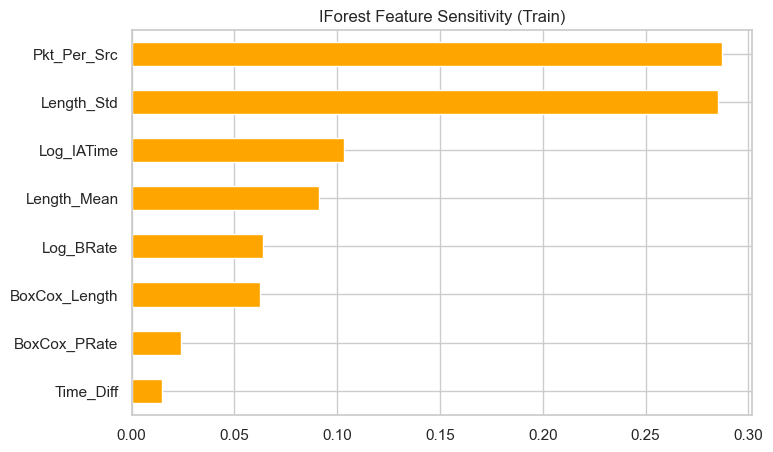

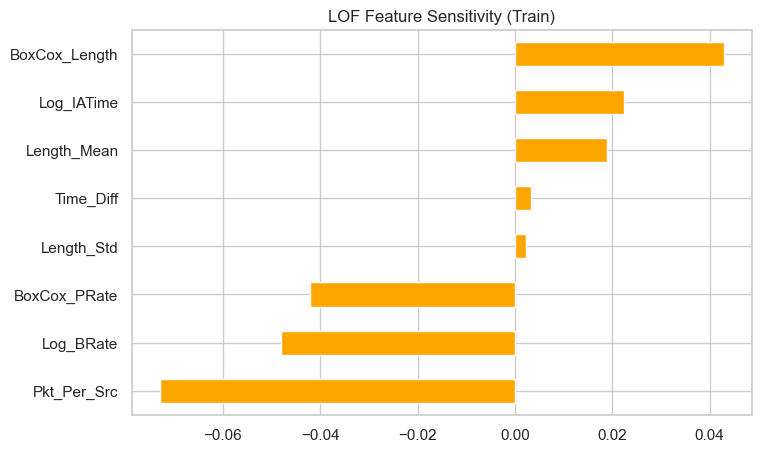

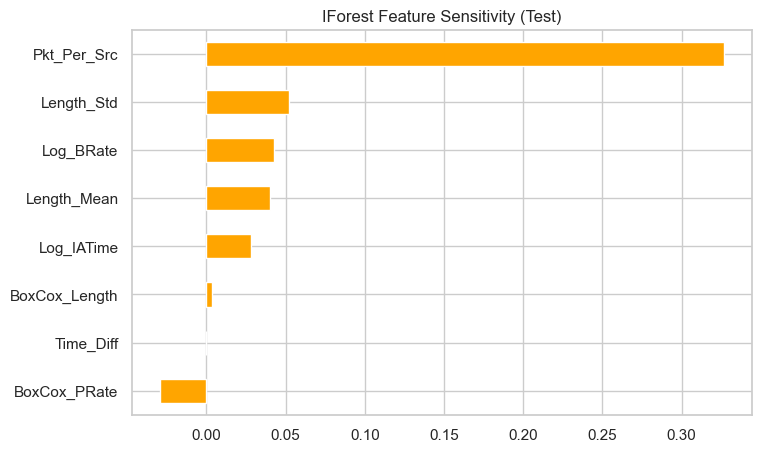

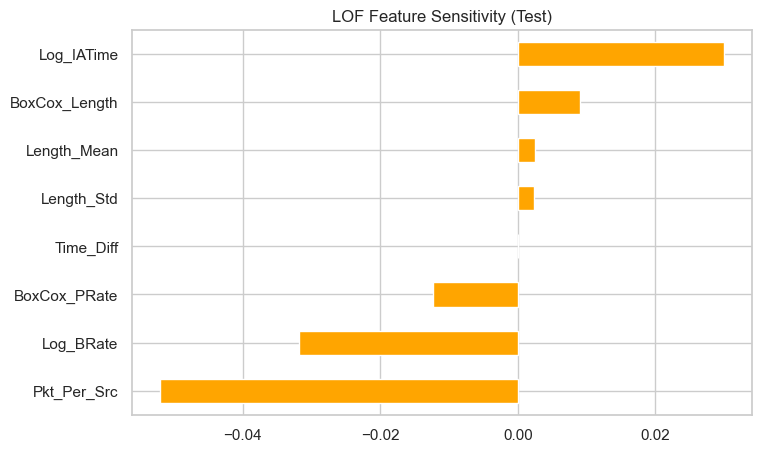

Plotting KDE distributions...


In [12]:
def feature_sensitivity(df_scaled, features, label_col):
    results = {}
    for f in features:
        mean_normal = df_scaled.loc[df_scaled[label_col]==1, f].mean()
        mean_anomaly = df_scaled.loc[df_scaled[label_col]==-1, f].mean()
        results[f] = mean_anomaly - mean_normal
    return results

fs_if_train = feature_sensitivity(df_train_scaled_full, NUM_FEATURES, "Anomaly_IForest")
fs_lof_train = feature_sensitivity(df_train_scaled_full, NUM_FEATURES, "Anomaly_LOF")
fs_if_test = feature_sensitivity(df_test_scaled_full, NUM_FEATURES, "Anomaly_IForest")
fs_lof_test = feature_sensitivity(df_test_scaled_full, NUM_FEATURES, "Anomaly_LOF")

# Bar plots
def plot_feature_sensitivity(results, title):
    plt.figure(figsize=(8,5))
    pd.Series(results).sort_values().plot(kind="barh", color="orange")
    plt.title(title)
    plt.show()

plot_feature_sensitivity(fs_if_train, "IForest Feature Sensitivity (Train)")
plot_feature_sensitivity(fs_lof_train, "LOF Feature Sensitivity (Train)")
plot_feature_sensitivity(fs_if_test, "IForest Feature Sensitivity (Test)")
plot_feature_sensitivity(fs_lof_test, "LOF Feature Sensitivity (Test)")

print("Plotting KDE distributions...")

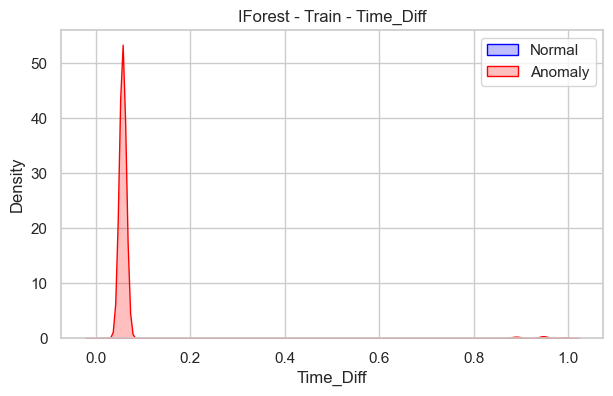

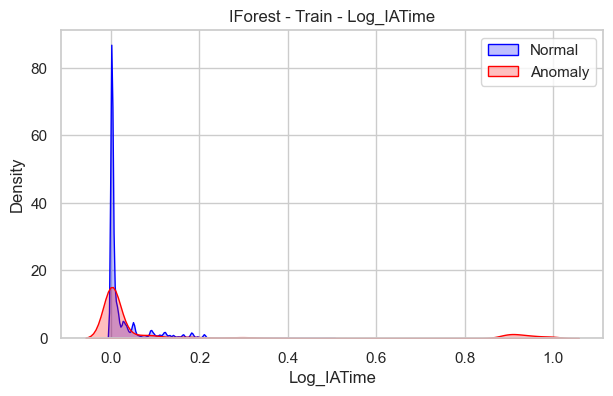

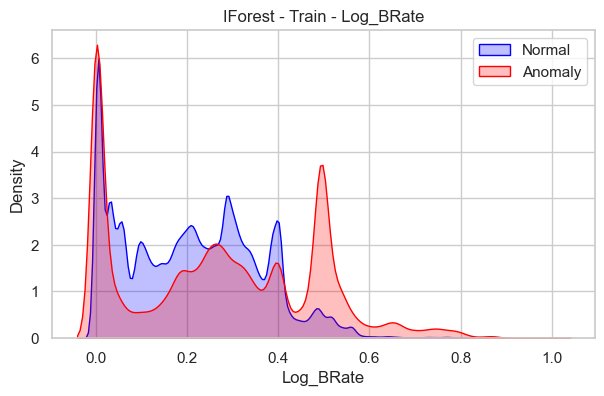

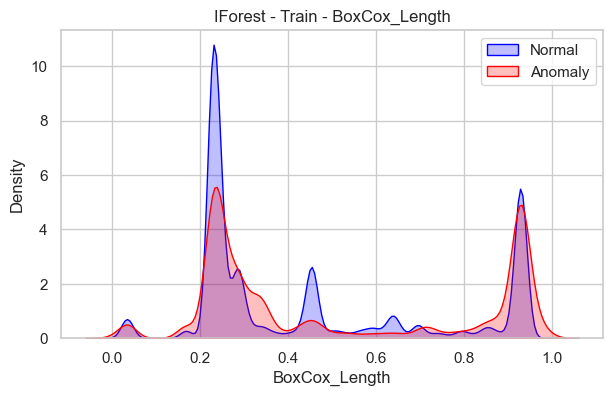

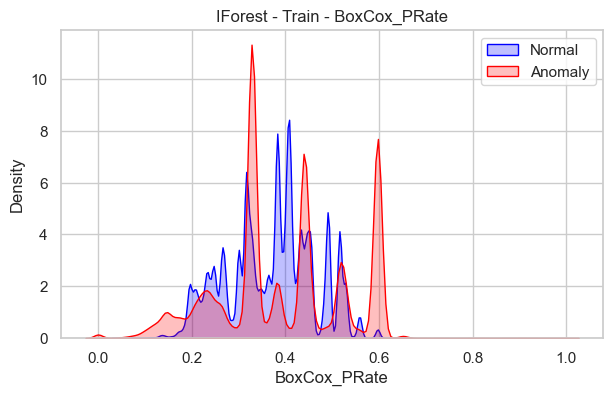

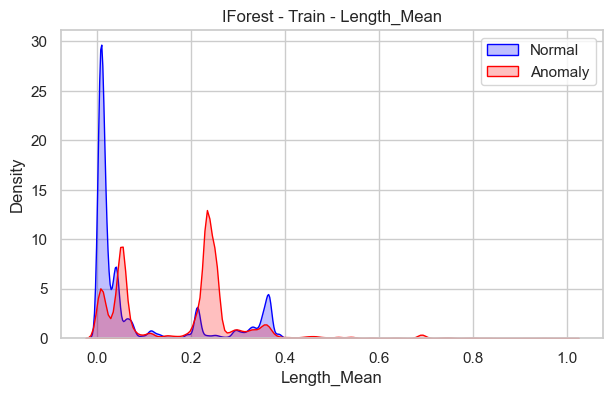

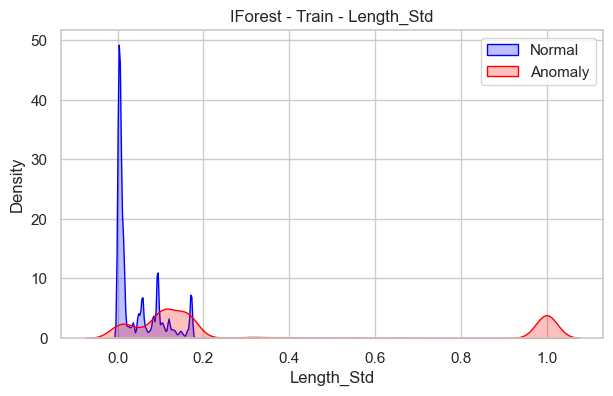

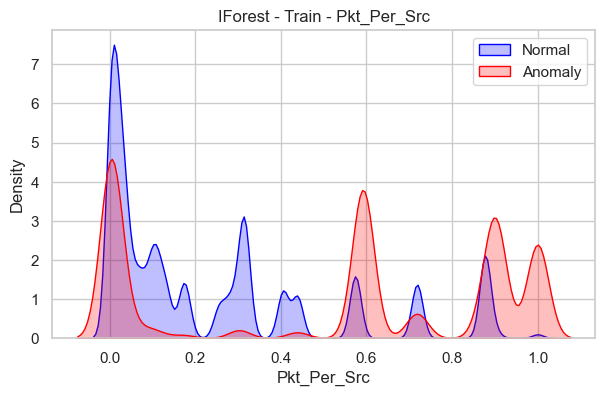

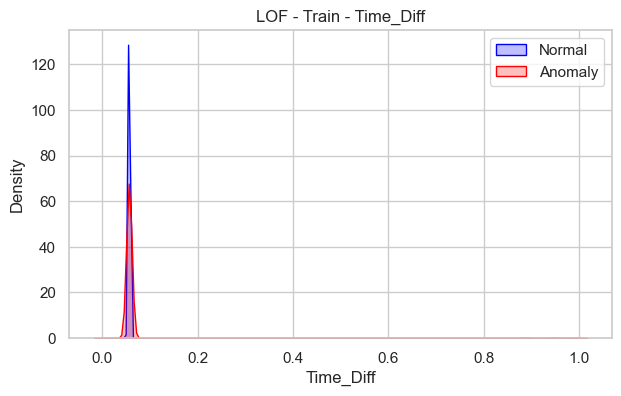

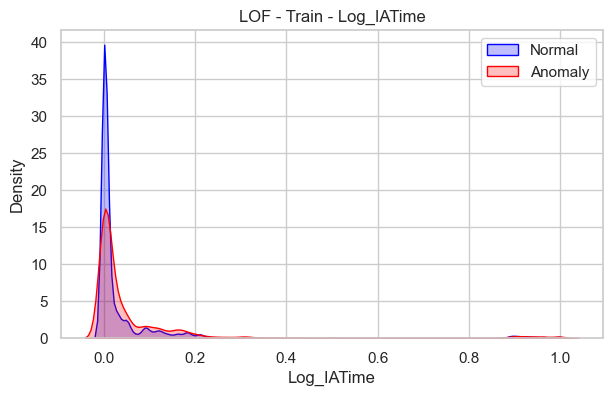

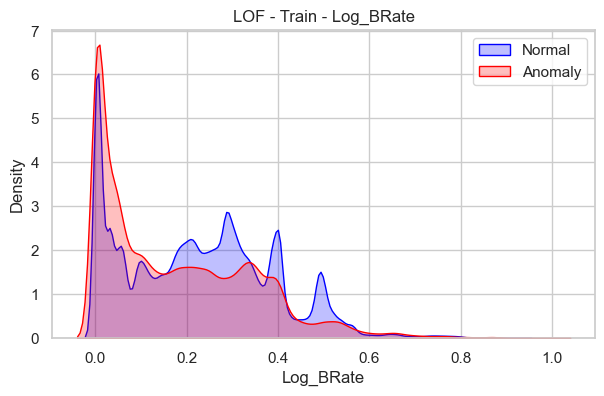

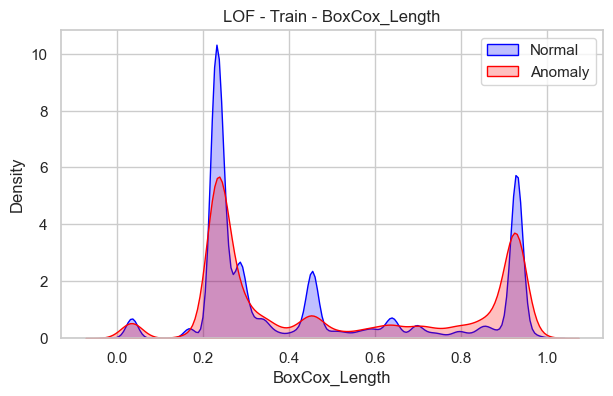

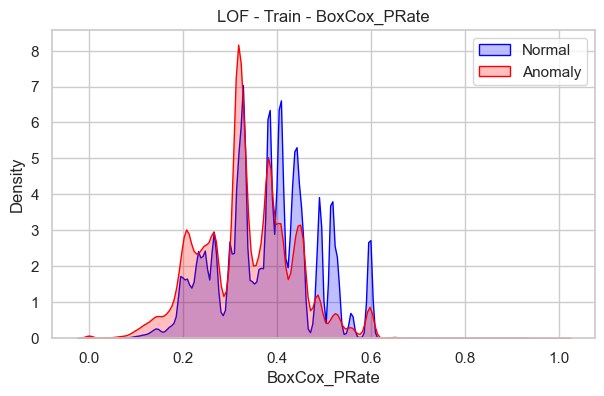

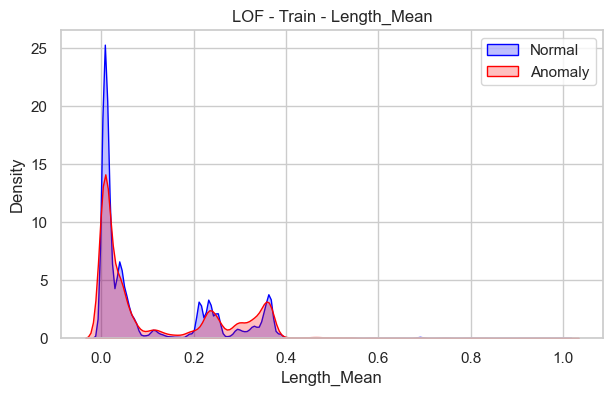

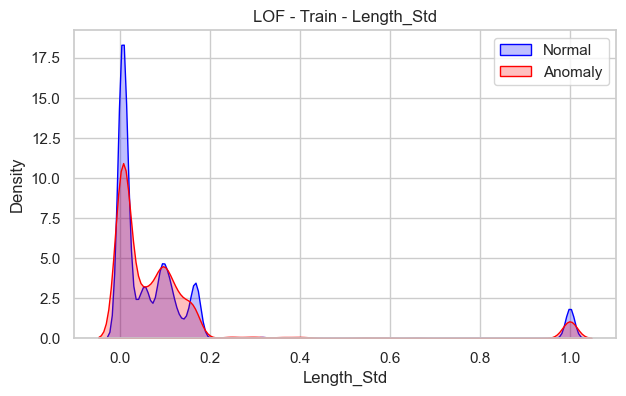

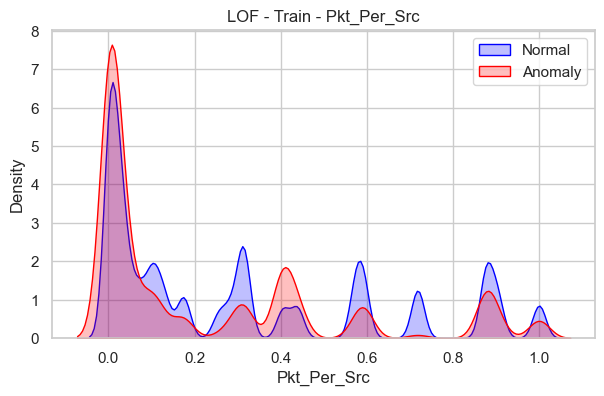

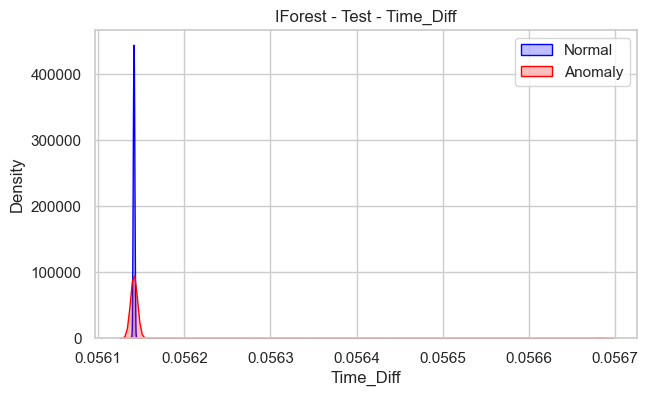

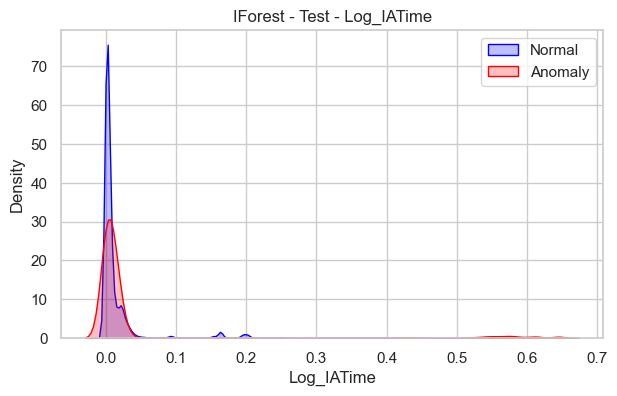

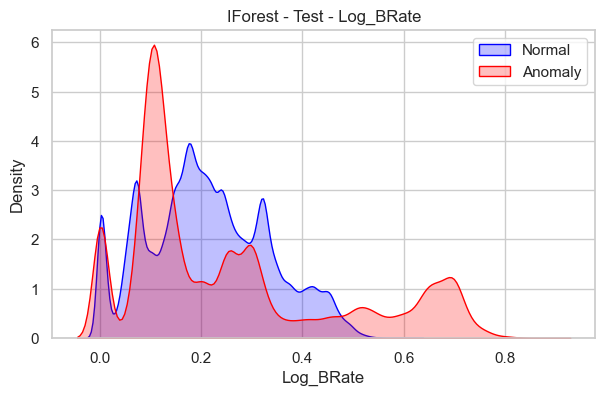

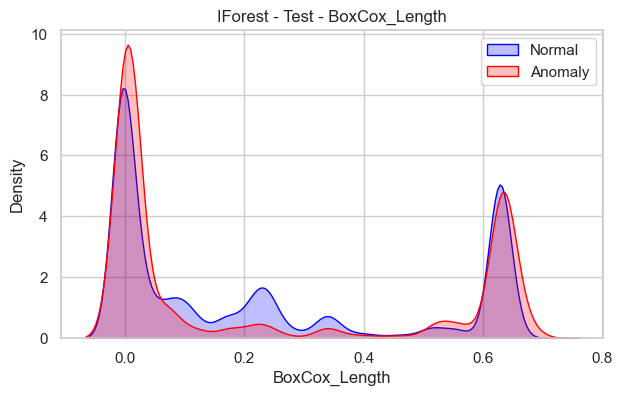

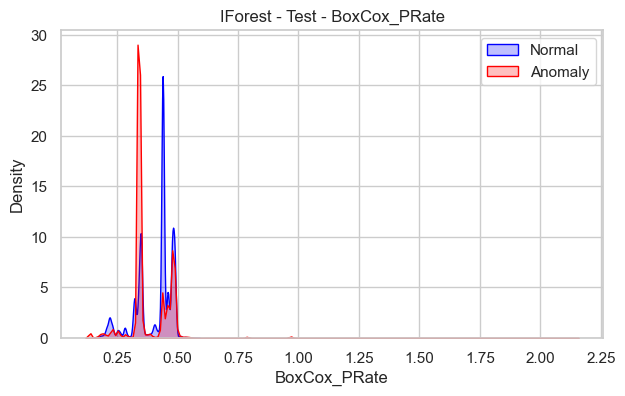

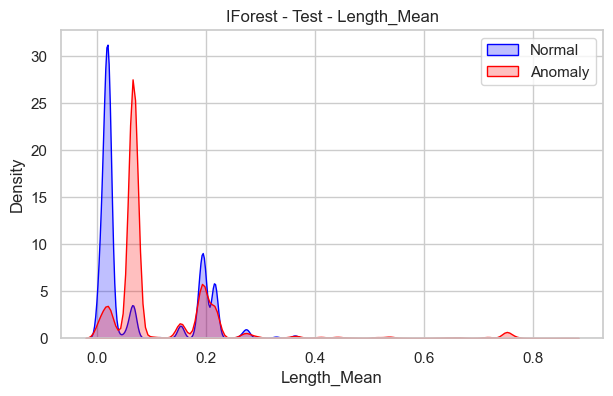

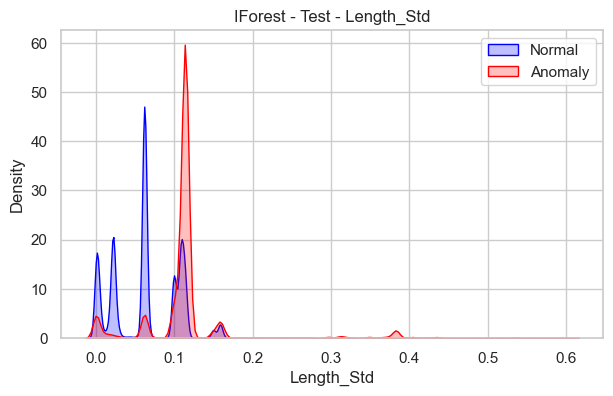

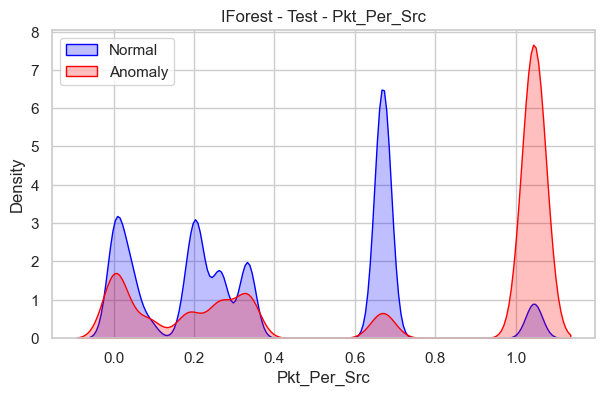

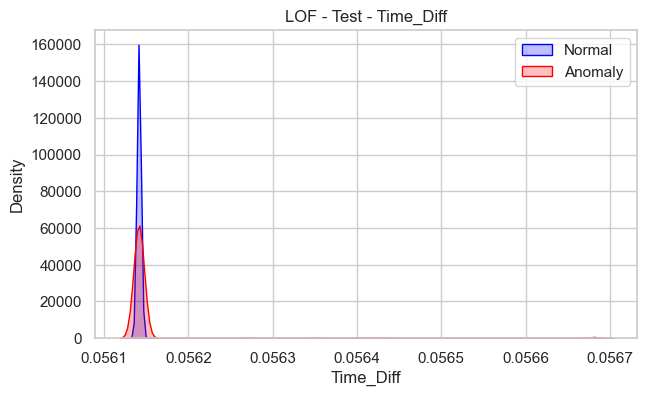

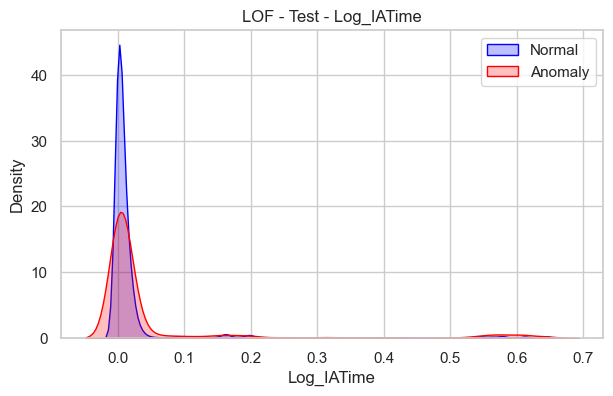

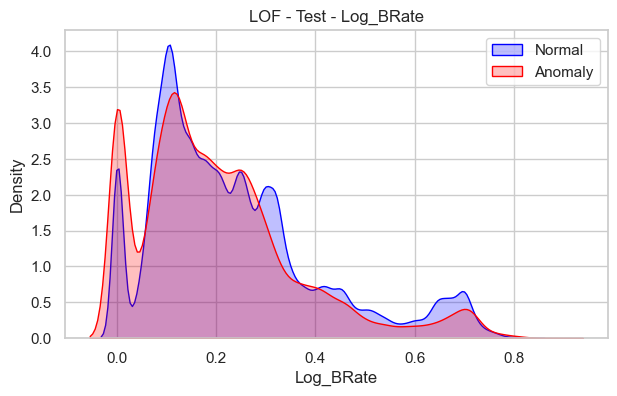

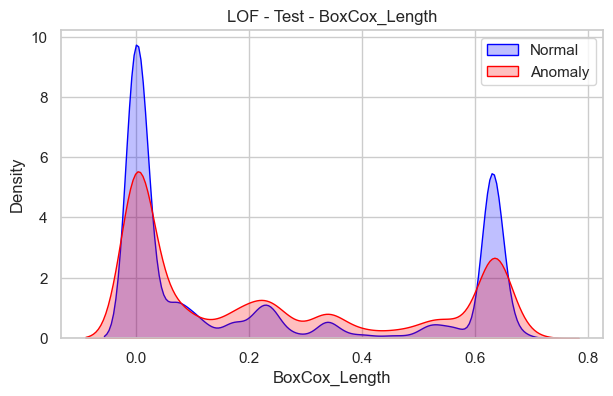

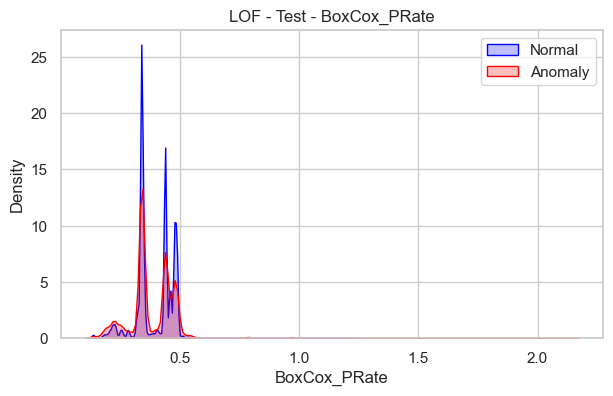

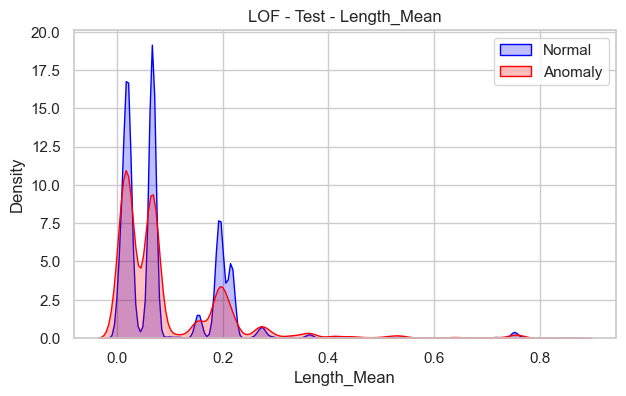

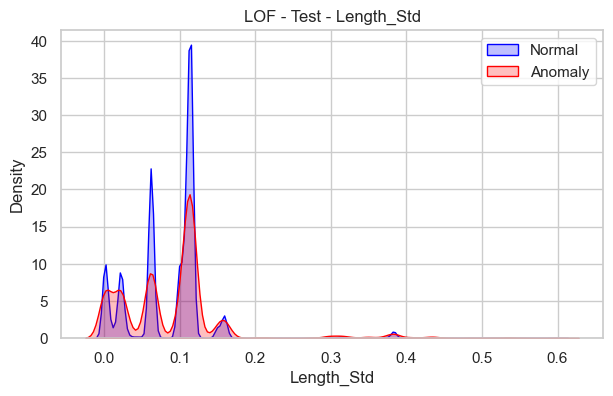

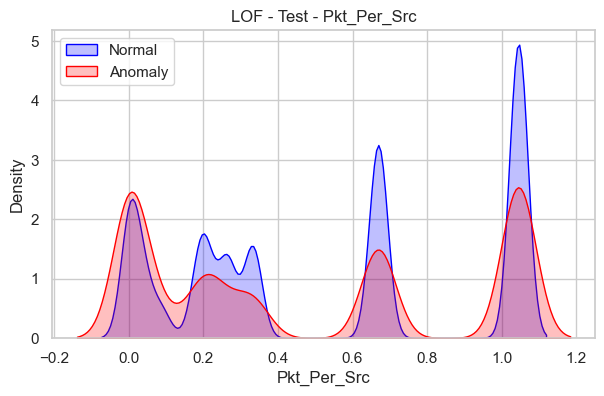

In [13]:
def kde_plots(df_scaled, features, label_col, model_name, dataset_name):
    for f in features:
        plt.figure(figsize=(7,4))
        sns.kdeplot(df_scaled.loc[df_scaled[label_col]==1, f], label="Normal", color="blue", fill=True)
        sns.kdeplot(df_scaled.loc[df_scaled[label_col]==-1, f], label="Anomaly", color="red", fill=True)
        plt.title(f"{model_name} - {dataset_name} - {f}")
        plt.legend()
        plt.show()

# KDE for train
kde_plots(df_train_scaled_full, NUM_FEATURES, "Anomaly_IForest", "IForest", "Train")
kde_plots(df_train_scaled_full, NUM_FEATURES, "Anomaly_LOF", "LOF", "Train")

# KDE for test
kde_plots(df_test_scaled_full, NUM_FEATURES, "Anomaly_IForest", "IForest", "Test")
kde_plots(df_test_scaled_full, NUM_FEATURES, "Anomaly_LOF", "LOF", "Test")
